# 100575020

# Pneumonia Prediction Using Chest X-Ray Images

# Introduction

Pneumonia is the inflammation of the lungs caused by an infection. Some symptoms of pneumonia include coughing, shortness of breath, chest pain and a high temperature (https://www.nhs.uk/conditions/pneumonia/).

In this notebook, I will develop an AI model that will be able to predict pneumonia from a xray picture of a persons chest. The dataset I am using is available at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia.





# Data preproccesing

First I need to import the libraries I will be using. Tensorflow will be the main machine learning library that I will use for my algorithms

In [14]:
import os
import numpy as np             
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

The dataset that i am using has three folders for the train, test and validation images. First, I will get the paths to these images:

In [15]:
testPath = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
trainPath = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
valPath = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"


The first thing that I need to do before i can train the model, is to perform some Image augmentation. Image augmentation is a technique that can artificially increase the size of image data which will in turn allow the model to have more accurate results once trained.

In [16]:
# Create the imageGenerator object to perform augmentation. This object will be used for training the model.
imageGenerator = ImageDataGenerator(
                                    
                                  rescale = 1./255,   # Set pixels of image to the 0 and 1 range instead of 0 255
                                  shear_range = 0.2,  # Create shearing effect
                                  zoom_range = 0.2,   # Zoom into images
                                  horizontal_flip = True  # Flip horizontally
                                   )

# Another imageGenerator that sets the pixels to 0 and 1 range. This will be used on the test data to ensure consistency.
testDataGenerator = ImageDataGenerator(rescale = 1./255)



Now i will create the data object for the images for each of the categories, train test and validate:

In [17]:

train = imageGenerator.flow_from_directory(
      trainPath,
      target_size=(224, 224),  # Resize images to 224px width and height for consistency
      color_mode='rgb',
      class_mode='binary',
      batch_size=32           # Each batch for training will contain 32 images
      )

test = testDataGenerator.flow_from_directory(
      testPath,
      target_size=(224, 224),
      color_mode='rgb',
      shuffle=False, 
      class_mode='binary',
      batch_size=32
      )

validate = testDataGenerator.flow_from_directory(
      valPath,
      target_size=(224, 224),
      color_mode='rgb',
      class_mode='binary', 
      batch_size=32
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


To test if the data works, lets print out some of the images using matplotlib

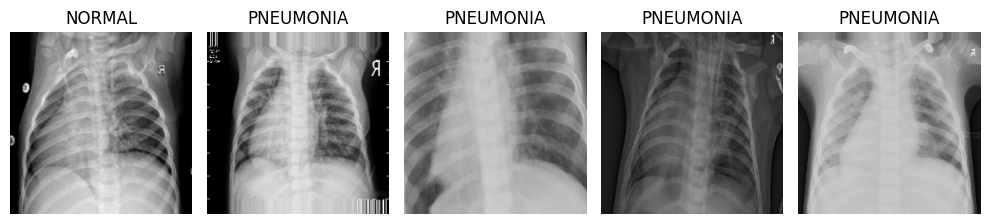

In [ ]:
plt.figure(figsize=(10, 10))

# Loop 5 times for 5 images
for i in range(0, 5):
    # Create sublpot
    plt.subplot(1, 5, i+1)
    # For every image and label which will be 0 or 1 create an image
    for image, label in train:
        img = image[1]    
        # If the label is 0 then the picture is normal if the label is 1 then the picture is of pneumonia
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(label[1]))
        plt.axis('off')
        plt.imshow(np.squeeze(img),cmap='gray')
        break
        
plt.tight_layout()
plt.show()

# Training the model with CNN

CNN (Convolutional Neural Network) is a deep learning algorithm thats used for analyzing visual data. The way it works is that the algorithm uses a series of layers of an image and shifts a filter through them. This filter is simply a smaller part of the image that is used to detect certain features about the main image. This process is called convoluting which is what the algorithm is named after. After the filter shifts through the layer, it return a feature map that can then be looked through again.

Using the tensorflow library I can instantiate a CNN model with the Sequential call which creates a CNN model that will stack layers sequantialy. I will also define the activation function to be the Rectified Linear Unit function. This function will be used in the model in order to introduce non-linearity which will yield more accurate results

In [19]:

channels = 16       # Number of features that the model will learn
filterSize = (3,3)  # Size of filter
activationFunction = "relu"    # Model will use Rectified Linear Unit function

# Initialize CNN model
CNNModel=Sequential()

After I have instantiaded the model, it is now time to add the different layers. I will add 3 different layers for this model, each one doubling the number of channels from the previous one in order for the model to learn more features which will yield more accurate results. After each layer i also create a pooling layer. Pooling layers reduce the width and height of the layer without losing the most important part of what has been learnt. This reduces the computational power required to train the model.

In [20]:
# Create first layer convolutional layer
CNNModel.add(layers.Conv2D(channels, filterSize, activation=activationFunction, input_shape=(224, 224, 3)))
# Add pooling layer
CNNModel.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Second layer
CNNModel.add(layers.Conv2D(channels * 2, filterSize, activation="relu", input_shape=(224, 224, 3)))
CNNModel.add(layers.MaxPooling2D(pool_size = (2, 2)))
CNNModel.add(layers.Conv2D(channels * 2, filterSize, activation="relu", input_shape=(224, 224, 3)))
CNNModel.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Third layer
CNNModel.add(layers.Conv2D(channels * 4, filterSize, activation="relu", input_shape=(224, 224, 3)))
CNNModel.add(layers.MaxPooling2D(pool_size = (2, 2)))
CNNModel.add(layers.Conv2D(channels * 4, filterSize, activation="relu", input_shape=(224, 224, 3)))
CNNModel.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Final layer
CNNModel.add(layers.Flatten())
CNNModel.add(layers.Dense(activation = 'relu', units = 128))
CNNModel.add(layers.Dense(activation = 'relu', units = 64))
# For the last layer i will use the sigmoid activation function. This is because sigmoid maps the output to be 0 or 1 which is what is needed for this model
CNNModel.add(layers.Dense(activation = 'sigmoid', units = 1))




Now that all the layers have been added its time to compile the model. When compiling the model, it needs an optimizer a loss function and a metric. In this case i will use the adam optimizer which is adaptive algorithm that is efficient. The loss function will be binary crossentropy since the model results will either be 0 or 1 (Normal or Pneumonia) and the accuracy metric will show how sucessful the model was in %

In [21]:
CNNModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
CNNModel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,009 (1.08 MB)

 Trainable params: 283,009 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Now I can train the model. Before i can do this I need to calculate the class weight. This is because the dataset I am using does not have the same ammount of pneumonia and normal images. This can yield innacurate results and thus needs to be adjusted before the model is trained.
I also create callbacks to stop training and reduce learning rate if the val_loss metric does not improve. If it consistently doesnt improve for a couple of epochs then then there is no point in over fitting the model.

In [22]:
# Calculate class weight using 'balanced' adjusts the class weight based on the class frequencies
weights = compute_class_weight(
                               'balanced', 
                               classes=np.unique(train.classes), 
                               y=train.classes
                               )
cw = dict(zip(np.unique(train.classes), weights))

# Create callback to stop training if val_loss doesnt not improve after 3 epochs
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
# Create callback to reduce learning rate if the val_loss doesnt improve after 2 epochs
lRR = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, lRR]

CNNModel.fit(train, epochs=50, validation_data=validate, class_weight=cw, callbacks=callbacks_list)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.6274 - loss: 0.5579 - val_accuracy: 0.7500 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8782 - loss: 0.2571 - val_accuracy: 0.8750 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8995 - loss: 0.2289
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8995 - loss: 0.2289 - val_accuracy: 0.8125 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9179 - loss: 0.1900 - val_accuracy: 0.7500 - val_loss: 0.6040 - learning_rate: 3.0000e-04


Now that the model has been trained we can check its accuracy.

In [23]:
accuracy = CNNModel.evaluate(test)
print(accuracy[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 537ms/step - accuracy: 0.8733 - loss: 0.3482
0.8958333134651184


As we can see the accuracy is 90% which is very high. Lets try out the model on some sample images to see if it can predict pneumonia. To do this i first need to generate prediction data from the model.

In [24]:
preds = CNNModel.predict(test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step


Now i can get some batches of data and iterate through them comparing them to the actual case thats set on the dataset.

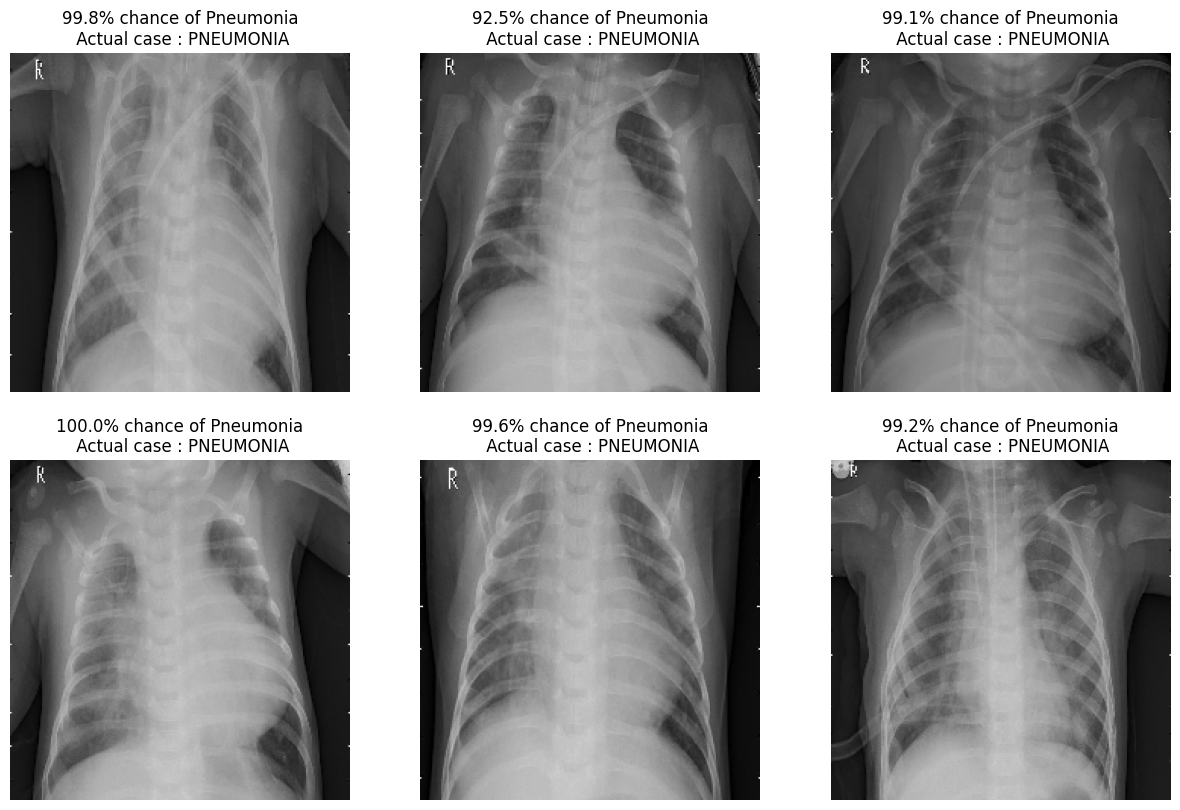

In [25]:
x_batches = []
y_batches = []

# Iterate over the DirectoryIterator to get batches of data
for i in range(test.__len__()):
    batch_x, batch_y = test[i]
    x_batches.append(batch_x)
    y_batches.append(batch_y)

# Concatenate the batches to get the final arrays
x = np.concatenate(x_batches)
y = np.concatenate(y_batches)


dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(15, 15))
for i in range(0 +300, 6 +300):
  plt.subplot(3, 3, (i -300)+1)
  if preds[i, 0] >= 0.5: 
      line = ('{:.1%} chance of Pneumonia'.format(preds[i][0]))      
  plt.title(line+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

# Conclusion
In conclusion, I have been able to train a model that can accuratly predict pneumonia from an X-ray image. The algorithm used in this solution was the CNN algorithm so it might be worthwile to try some other algorithms like Transfer Learning. CNN is an algorithm that is built from the ground up while other algorithms like Transfer Learning get applied over already existing models which could yield even more accuracy.